<a href="https://colab.research.google.com/github/donghuna/AI_Expert_Lecture_Files/blob/main/Lab3_1_cGAN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import PIL

### Generative Adversarial Networks
#### Generator
- Generates fake images
- Get labels to generates specific images

In [2]:
class GeneratorCNN(nn.Module):
    def __init__(self,latent_size):
        super(GeneratorCNN, self).__init__()
        self.latent_size = latent_size

        # Fully connected layer to upscale the latent vector
        self.fc1 = nn.Linear(self.latent_size + 10, 128 * 7 * 7)  # 7x7 크기로 변환

        # Convolutional layers to generate an image
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def generator(self, label):
        batch_size = label.shape[0] # 첫번재 dim 값이 배치 크기이다
        z = torch.randn((batch_size, self.latent_size)) # 정규 분포에서 샘플링된 batch_size x latent_size 크기의 잠재 벡터
        if torch.cuda.is_available():
            z = z.cuda()

        # Concatenate latent vector and label
        z = torch.cat([z, label], dim=1)

        # Fully connected layer
        x = self.fc1(z)
        x = self.relu(x)

        # Reshape to (batch_size, 128, 7, 7)
        x = x.view(batch_size, 128, 7, 7)

        # Transpose convolutional layers
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        img = self.sigmoid(x)

        return img

    def forward(self,label):
        img = self.generator(label)
        return img

#### Discriminator
- Find fake images

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.conv1 = nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc1 = nn.Linear(128 * 7 * 7, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,img,label):
        label = label.view(label.size(0), 10, 1, 1)  # (batch_size, 10, 1, 1)
        label = label.repeat(1, 1, 28, 28)  # (batch_size, 10, 28, 28)
        x = torch.cat([img, label], dim=1)  # (batch_size, 11, 28, 28)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

#### Util functions

In [4]:
def one_hot(x):
    res = torch.zeros((x.shape[0],10))
    for i in range(x.shape[0]):
        res[i,x[i]]=1
    return res

#### Hyperparameters

In [5]:
NUM_EPOCHS = 150
BATCH_SIZE = 128
LATENT_SIZE = 100
LEARNING_RATE = 2e-4
EPS = 1e-6
LEARNING_RATIO = 1

#### Dataloader

In [6]:
transforms = Compose([
    ToTensor(),
])

trainset = MNIST('./',train=True,transform=transforms,download=True)
testset = MNIST('./',train=False,transform=transforms,download=True)

args = {
    'num_workers' : 1,
    'batch_size' : BATCH_SIZE,
    'shuffle' : True,
}

train_loader = DataLoader(trainset,**args)
test_loader = DataLoader(testset,**args)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4461962.17it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133716.70it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1264700.39it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4608255.63it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



#### Training part

epoch 1
 gen : 1087.90849	 dis : 376.96678


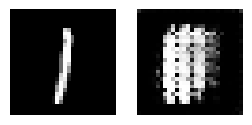

epoch 2
 gen : 877.72448	 dis : 378.39996


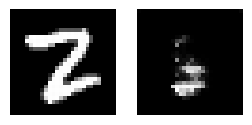

epoch 3
 gen : 900.20130	 dis : 314.13256


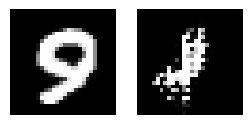

epoch 4
 gen : 870.55515	 dis : 324.21618


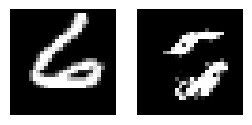

epoch 5
 gen : 950.97609	 dis : 349.21768


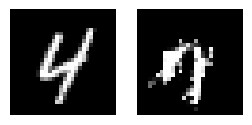

epoch 6
 gen : 733.97857	 dis : 420.80698


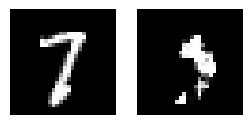

epoch 7
 gen : 692.22828	 dis : 404.28158


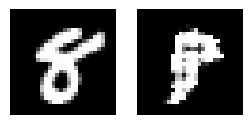

epoch 8
 gen : 679.53461	 dis : 426.00703


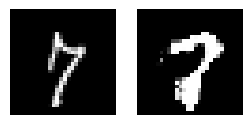

epoch 9
 gen : 669.56297	 dis : 404.72916


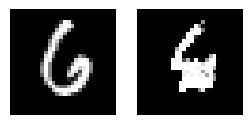

epoch 10
 gen : 691.42654	 dis : 386.28383


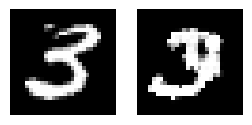

epoch 11
 gen : 710.91304	 dis : 372.85677


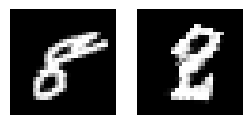

epoch 12
 gen : 719.16481	 dis : 383.24795


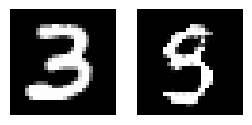

epoch 13
 gen : 693.40181	 dis : 401.21054


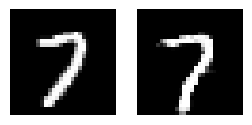

epoch 14
 gen : 663.89828	 dis : 415.68300


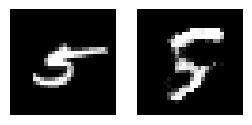

epoch 15
 gen : 642.48491	 dis : 442.32693


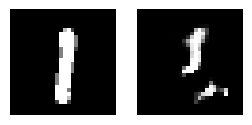

epoch 16
 gen : 616.84768	 dis : 450.92474


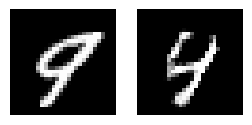

epoch 17
 gen : 589.49815	 dis : 463.30625


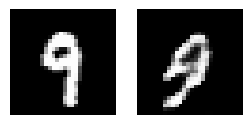

epoch 18
 gen : 573.31682	 dis : 480.87963


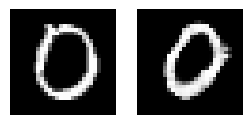

epoch 19
 gen : 668.21223	 dis : 518.44071


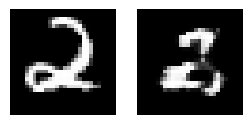

epoch 20
 gen : 561.26281	 dis : 519.04398


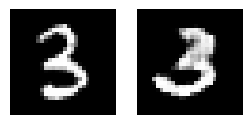

epoch 21
 gen : 524.77182	 dis : 492.49024


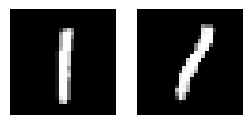

epoch 22
 gen : 518.44277	 dis : 494.87009


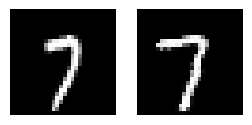

epoch 23
 gen : 524.39377	 dis : 495.60462


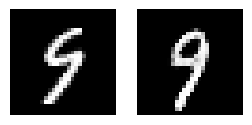

epoch 24
 gen : 536.29050	 dis : 499.18354


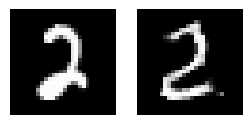

epoch 25
 gen : 541.40635	 dis : 507.23877


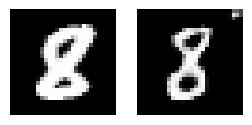

epoch 26
 gen : 521.26446	 dis : 511.44987


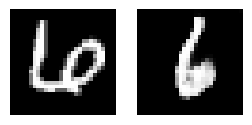

epoch 27
 gen : 522.89228	 dis : 513.95883


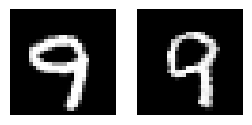

epoch 28
 gen : 509.95672	 dis : 516.85444


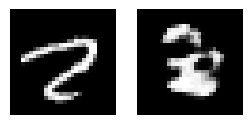

epoch 29
 gen : 511.36823	 dis : 519.28277


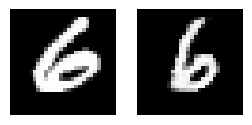

epoch 30
 gen : 512.31226	 dis : 521.04572


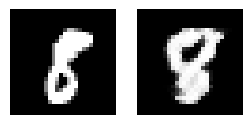

epoch 31
 gen : 512.82636	 dis : 518.38072


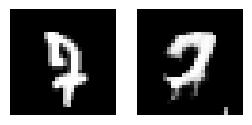

epoch 32
 gen : 519.62582	 dis : 523.22672


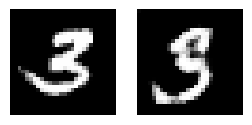

epoch 33
 gen : 502.31062	 dis : 519.10945


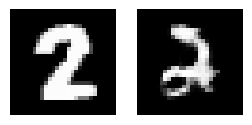

epoch 34
 gen : 500.96087	 dis : 521.14914


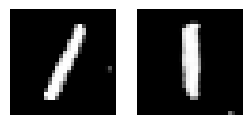

epoch 35
 gen : 509.99266	 dis : 516.87994


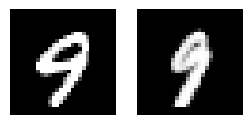

epoch 36
 gen : 511.84297	 dis : 518.98837


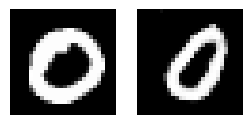

epoch 37
 gen : 497.68776	 dis : 516.23084


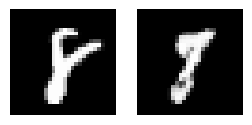

epoch 38
 gen : 497.18363	 dis : 514.78763


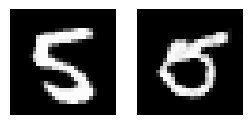

epoch 39
 gen : 507.91362	 dis : 512.26930


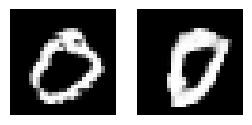

epoch 40
 gen : 501.52142	 dis : 508.09383


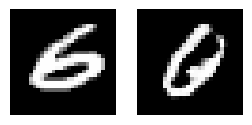

epoch 41
 gen : 512.43289	 dis : 507.43736


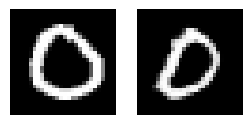

epoch 42
 gen : 505.52246	 dis : 502.65576


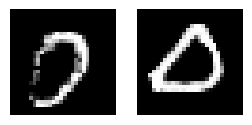

epoch 43
 gen : 505.91166	 dis : 499.89289


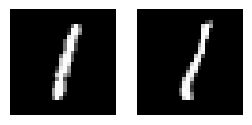

epoch 44
 gen : 511.39674	 dis : 497.72472


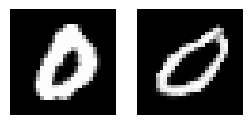

epoch 45
 gen : 514.14004	 dis : 495.83300


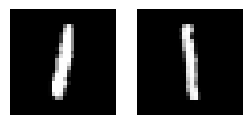

epoch 46
 gen : 516.63358	 dis : 497.54780


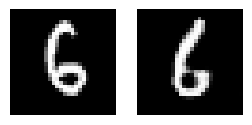

epoch 47
 gen : 518.52583	 dis : 494.53846


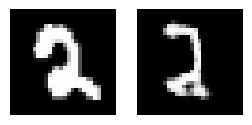

epoch 48
 gen : 523.68949	 dis : 490.21283


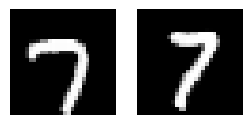

epoch 49
 gen : 525.83328	 dis : 490.38638


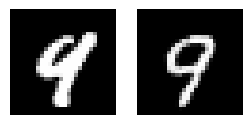

epoch 50
 gen : 528.38344	 dis : 490.13005


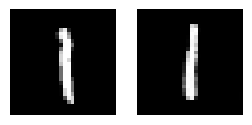

epoch 51
 gen : 522.16728	 dis : 487.05059


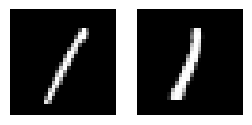

epoch 52
 gen : 526.11246	 dis : 488.54193


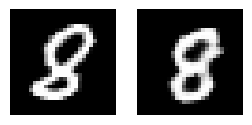

epoch 53
 gen : 536.05639	 dis : 487.27215


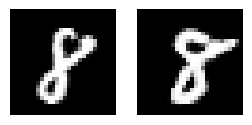

epoch 54
 gen : 527.01216	 dis : 486.13161


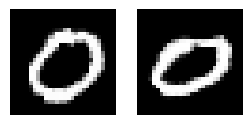

epoch 55
 gen : 531.37930	 dis : 486.10210


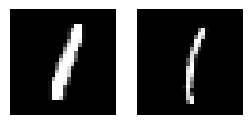

epoch 56
 gen : 532.54418	 dis : 486.53363


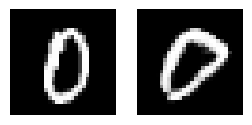

epoch 57
 gen : 528.65353	 dis : 489.22165


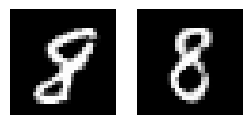

epoch 58
 gen : 527.50870	 dis : 487.38729


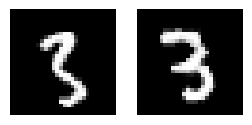

epoch 59
 gen : 529.02926	 dis : 489.80442


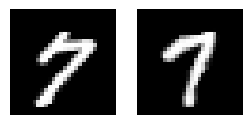

epoch 60
 gen : 531.65944	 dis : 492.13516


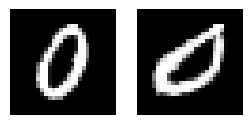

epoch 61
 gen : 529.07150	 dis : 492.79655


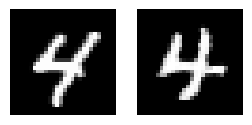

epoch 62
 gen : 532.07865	 dis : 496.95221


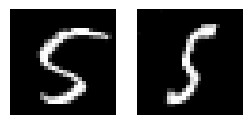

epoch 63
 gen : 521.49055	 dis : 496.00262


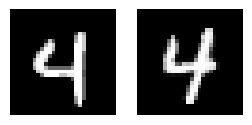

epoch 64
 gen : 521.57220	 dis : 499.19243


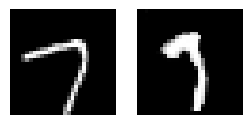

epoch 65
 gen : 519.89999	 dis : 503.84660


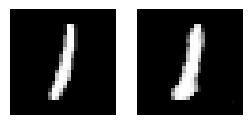

epoch 66
 gen : 524.40783	 dis : 503.88771


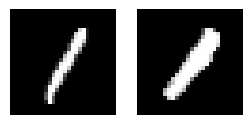

epoch 67
 gen : 513.96198	 dis : 504.94869


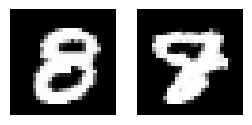

epoch 68
 gen : 512.97451	 dis : 508.11333


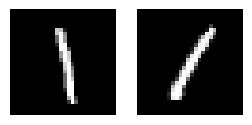

epoch 69
 gen : 507.49567	 dis : 509.11134


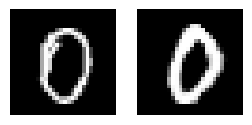

epoch 70
 gen : 507.12678	 dis : 511.52955


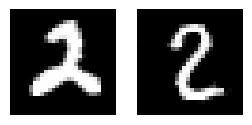

epoch 71
 gen : 503.98812	 dis : 514.21863


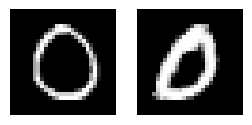

epoch 72
 gen : 502.97462	 dis : 515.29427


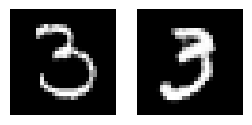

epoch 73
 gen : 497.88281	 dis : 517.82633


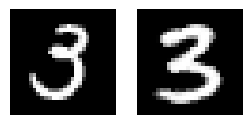

epoch 74
 gen : 493.45924	 dis : 519.97818


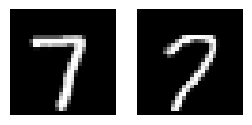

epoch 75
 gen : 495.23907	 dis : 521.78956


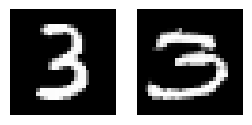

epoch 76
 gen : 499.27411	 dis : 524.42736


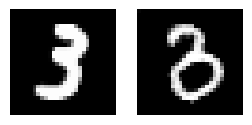

epoch 77
 gen : 492.25420	 dis : 525.04962


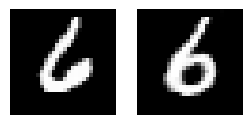

epoch 78
 gen : 490.53281	 dis : 523.87611


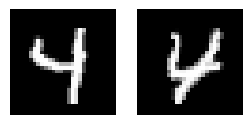

epoch 79
 gen : 495.82646	 dis : 525.14580


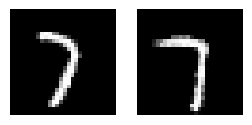

epoch 80
 gen : 509.54156	 dis : 525.03361


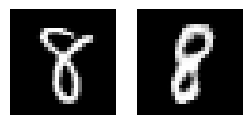

epoch 81
 gen : 505.82079	 dis : 523.87555


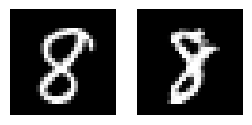

KeyboardInterrupt: 

In [10]:
gen = GeneratorCNN(LATENT_SIZE)
dis = Discriminator()
if torch.cuda.is_available():
    gen = gen.cuda()
    dis = dis.cuda()

# gen_parameters = filter(lambda p: p.requires_grad, gen.parameters())
# num_params = sum([np.prod(p.size()) for p in gen_parameters])
# print("number of parameters(generator) : {}".format(num_params))
# dis_parameters = filter(lambda p: p.requires_grad, dis.parameters())
# num_params = sum([np.prod(p.size()) for p in dis_parameters])
# print("number of parameters(discriminator) : {}".format(num_params))

optimizer_G = Adam(gen.parameters(),lr=LEARNING_RATE)
optimizer_D = Adam(dis.parameters(),lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    tot_gen_loss = 0
    tot_dis_loss = 0
    cnt = 0
    for img,label in train_loader:
        onehot_label = one_hot(label).float()
        if torch.cuda.is_available():
            img = img.cuda()
            onehot_label = onehot_label.cuda()

        if cnt % LEARNING_RATIO == 0:
            optimizer_D.zero_grad()
            real = dis(img,onehot_label)
            img_ = gen(onehot_label)
            fake = dis(img_,onehot_label)
            dis_loss = -torch.mean(torch.log(real+EPS)+torch.log(1+EPS-fake))
            dis_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        img_ = gen(onehot_label)
        fake = dis(img_,onehot_label)
        gen_loss = -torch.mean(torch.log(fake+EPS))
        gen_loss.backward()
        optimizer_G.step()
        tot_dis_loss +=dis_loss.item()
        tot_gen_loss +=gen_loss.item()
        cnt+=1

    print("epoch {}\n gen : {:.5f}\t dis : {:.5f}".format(epoch+1, tot_gen_loss, tot_dis_loss))
    img, label = next(iter(test_loader))
    onehot_label = one_hot(label)
    if torch.cuda.is_available():
        onehot_label = onehot_label.cuda()
    img_ = gen(onehot_label)
    fig = plt.figure(figsize=(3,3))
    fig.add_subplot(1,2,1)
    plt.imshow(img[0].squeeze().numpy(),cmap='gray')
    plt.axis('off')
    img_out = img_[0].squeeze().cpu().detach().numpy()
    fig.add_subplot(1,2,2)
    plt.imshow(img_out,cmap='gray')
    plt.axis('off')
    plt.show()